<a href="https://colab.research.google.com/github/Minupama/PatternRecognition_Assignment/blob/main/VGG16(unfreezed_parameters(210733L)).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers, models

In [ ]:
# Paths for Google Drive and dataset
drive_path = "/content/drive/MyDrive/defungi"  # Update if needed
base_dir = "/content/defungi_split"           # Local directory for train/val/test
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

In [ ]:
# Step 1: Create directories for train, val, and test
def create_split_dirs():
    for dir_path in [train_dir, val_dir, test_dir]:
        os.makedirs(dir_path, exist_ok=True)

In [ ]:
# Step 2: Split dataset into train, validation, and test
def split_dataset(source_dir, train_dir, val_dir, test_dir, train_ratio=0.6, val_ratio=0.2, seed=123):
    subfolders = [f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))]

    for subfolder in subfolders:
        subfolder_path = os.path.join(source_dir, subfolder)

        # Check if there are images in the subfolder
        images = [f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))]
        if len(images) == 0:
            print(f"Warning: No images found in {subfolder}. Skipping...")
            continue  # Skip subfolder if no images

        # Split images into train, validation, and test
        train_images, temp_images = train_test_split(images, train_size=train_ratio, random_state=seed)
        val_images, test_images = train_test_split(temp_images, test_size=val_ratio/(1-train_ratio), random_state=seed)

        # Copy images to respective folders
        for image_set, target_dir in [(train_images, train_dir), (val_images, val_dir), (test_images, test_dir)]:
            class_dir = os.path.join(target_dir, subfolder)
            os.makedirs(class_dir, exist_ok=True)
            for image in image_set:
                shutil.copy(os.path.join(subfolder_path, image), os.path.join(class_dir, image))

# Prepare directories
create_split_dirs()
split_dataset(drive_path, train_dir, val_dir, test_dir)

In [ ]:
# Step 3: Preprocessing images using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 5466 images belonging to 5 classes.


In [ ]:
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
validation_steps = val_generator.samples // val_generator.batch_size
import math
validation_steps = math.ceil(val_generator.samples / val_generator.batch_size)


Found 1824 images belonging to 5 classes.


In [ ]:
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1824 images belonging to 5 classes.


In [ ]:
# Step 4: Setting up VGG16 model
from tensorflow.keras import applications

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

# Load the VGG16 model with pre-trained ImageNet weights, excluding the top layers
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the top few layers (for example, unfreeze the last 4 blocks)
for layer in base_model.layers[:-4]:  # Freeze all layers except the last 4 blocks
    layer.trainable = False

# Add custom layers on top of the base model
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.BatchNormalization()(x)  # Batch Normalization after pooling
x = layers.Dense(
    512,
    activation='relu',
    kernel_regularizer=regularizers.l2(0.01)  # Add L2 regularization
)(x)
x = layers.BatchNormalization()(x)  # Batch Normalization after Dense layer
x = layers.Dropout(0.5)(x)  # Dropout for regularization
x = layers.Dense(
    len(train_generator.class_indices),  # Number of classes in your dataset
    activation='softmax',
    kernel_regularizer=regularizers.l2(0.01)  # Add L2 regularization to output layer
)(x)

# Create the final model
model = tf.keras.Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,0

 Total params: 14,984,005 (57.16 MB)

 Trainable params: 7,346,693 (28.03 MB)

 Non-trainable params: 7,637,312 (29.13 MB)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    verbose=1  # To display progress
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


171/171 ━━━━━━━━━━━━━━━━━━━━ 72s 312ms/step - accuracy: 0.4784 - loss: 6.6197 - val_accuracy: 0.5800 - val_loss: 5.6773
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 49s 210ms/step - accuracy: 0.5860 - loss: 5.5179 - val_accuracy: 0.5965 - val_loss: 5.1422
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 39s 227ms/step - accuracy: 0.6421 - loss: 4.8557 - val_accuracy: 0.6760 - val_loss: 4.5490
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 36s 209ms/step - accuracy: 0.6687 - loss: 4.4297 - val_accuracy: 0.6266 - val_loss: 4.8087
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 36s 210ms/step - accuracy: 0.6981 - loss: 3.9631 - val_accuracy: 0.6420 - val_loss: 4.0389
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 37s 211ms/step - accuracy: 0.7066 - loss: 3.6320 - val_accuracy: 0.6393 - val_loss: 3.6680
Epoch 7/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 36s 209ms/step - accuracy: 0.7245 - loss: 3.3574 - val_accuracy: 0.4874 - val_loss: 3.6007
Epoch 8/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 39s 225ms/step - accuracy: 0.7417 - loss: 3.0683 - val

In [ ]:
# Step 7: Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test accuracy: {test_acc * 100:.2f}%")

57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.5875 - loss: 2.0753
Test accuracy: 58.28%


In [ ]:
# Optionally: Save the model
model.save('/content/vgg16_model.h5')

In [ ]:
# Optionally: Plot the accuracy/loss curves
import matplotlib.pyplot as plt

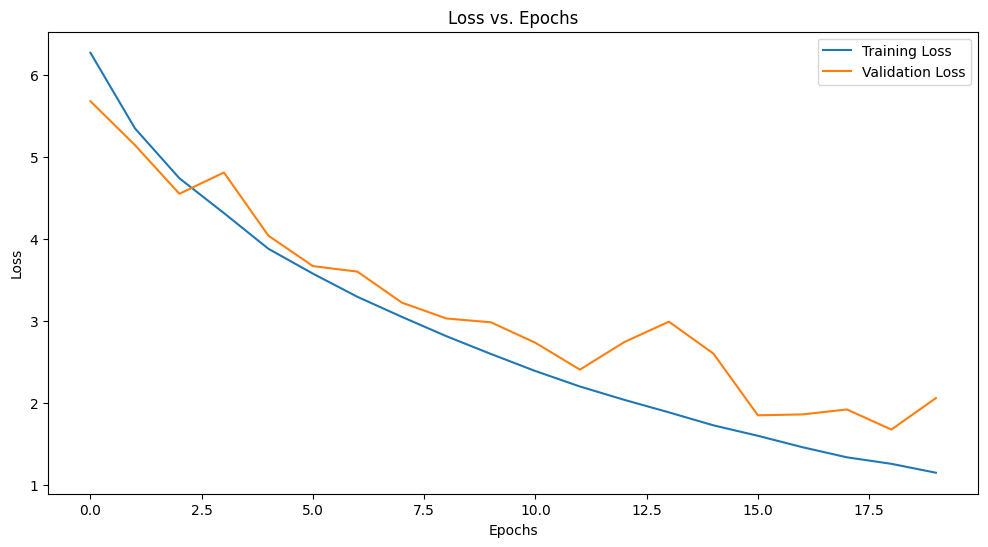

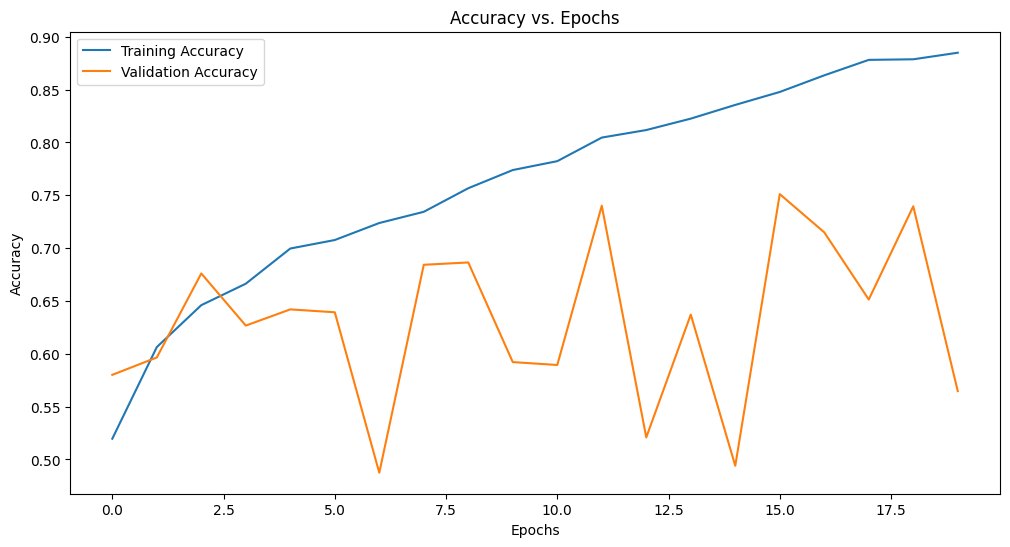

In [ ]:
#Plot Training and Validation Metrics
def plot_metrics(history):
    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
plot_metrics(history)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get true labels from the test generator
y_true = test_generator.classes

# Get predicted probabilities
y_pred_prob = model.predict(test_generator, verbose=1)

# Convert predicted probabilities to class indices
y_pred = np.argmax(y_pred_prob, axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step


In [ ]:
# Get the class labels
class_labels = list(test_generator.class_indices.keys())



# Generate a confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Confusion Matrix:
[[247 242  30 171 191]
 [113 132  21 100 101]
 [ 42  50   4  31  37]
 [ 47  37   8  29  43]
 [ 36  40   6  24  42]]


In [ ]:
# Classification Report
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

          H1       0.51      0.28      0.36       881
          H2       0.26      0.28      0.27       467
          H3       0.06      0.02      0.03       164
          H5       0.08      0.18      0.11       164
          H6       0.10      0.28      0.15       148

    accuracy                           0.25      1824
   macro avg       0.20      0.21      0.19      1824
weighted avg       0.33      0.25      0.27      1824



Confusion Matrix:
[[247 242  30 171 191]
 [113 132  21 100 101]
 [ 42  50   4  31  37]
 [ 47  37   8  29  43]
 [ 36  40   6  24  42]]


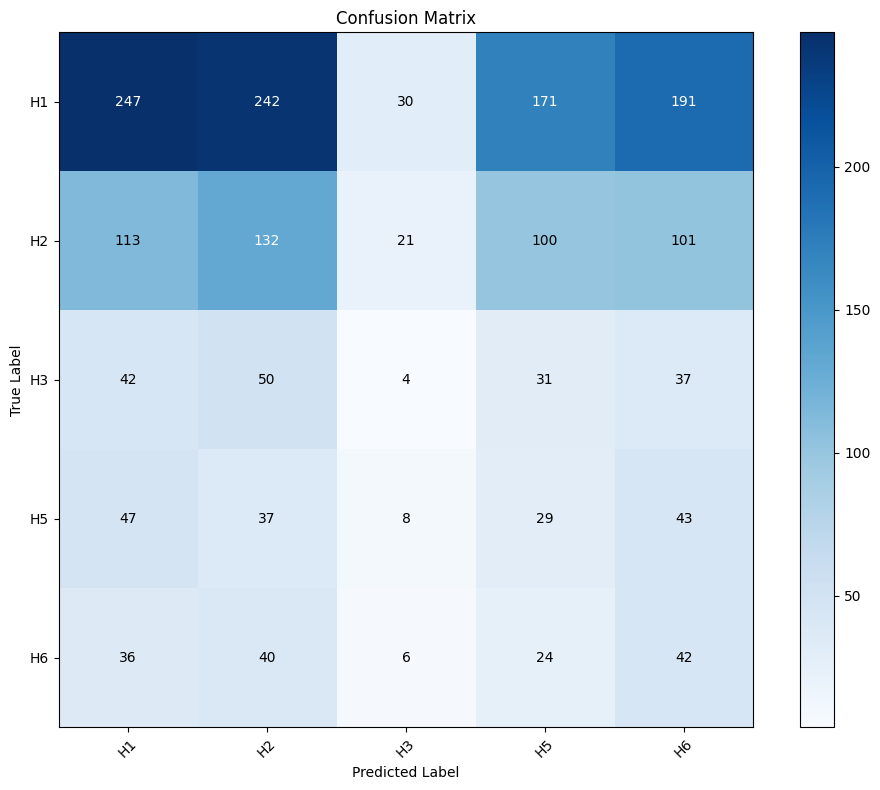

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix with Values
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add labels
tick_marks = np.arange(len(test_generator.class_indices))
class_labels = list(test_generator.class_indices.keys())
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Annotate cells with values
thresh = conf_matrix.max() / 2.0  # Set threshold for text color
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(
            j, i, format(conf_matrix[i, j], 'd'),
            ha="center", va="center",
            color="white" if conf_matrix[i, j] > thresh else "black"
        )
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()